# Normalizing flows

In [1]:
%cd ..

/data/mas322/amex-project


In [17]:
import yaml
import os
import importlib
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist 
import pyro.distributions.transforms as T

from src.experiments.static_preprocessing_methods.min_max_scaling import MinMaxTimeSeries
from src.experiments.static_preprocessing_methods.standard_scaling import StandardScalerTimeSeries
from src.lib import experimentation
import src.experiments.static_preprocessing_methods.experiment_setup as spm

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

LOAD_DATA = True

if LOAD_DATA:
    # load corrupted data
    torch.manual_seed(42)
    train_loader, val_loader = experimentation.load_numpy_data(
        os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
        val_idx=[0, 1],
        fill_dict=fill_dict,
        preprocess_obj=MinMaxTimeSeries(),
        corrupt_func=spm.undo_min_max_corrupt_func,
        dtype=torch.float32,
        **data_loader_kwargs)

    for X, y in train_loader:
        break
    X, y = X.numpy()[:, :, 11:], y.numpy()[11:]
    print(f"X shape: {X.shape}")

X shape: (1024, 13, 177)


## Util methods

In [202]:
# example
def get_iaf_bijector(num_layers, scale_and_shift_dims, input_dim, dev, random_state=42):
    transforms = []
    layers_left = num_layers
    while layers_left > 0:
        # for reproducibility
        torch.random.manual_seed(random_state + layers_left)
        
        # create the permutations
        perm = torch.randperm(input_dim, dtype=torch.long, device=dev)
        inv_perm = torch.empty_like(perm, device=dev)
        inv_perm[perm] = torch.arange(input_dim, device=dev)
        
        # first affine autoregressive layer
        scale_and_shift = pyro.nn.AutoRegressiveNN(input_dim, scale_and_shift_dims, param_dims=[1, 1])
        transforms.append(T.AffineAutoregressive(scale_and_shift, stable=True))
        if layers_left == 1:
            break
        transforms.append(T.Permute(perm))

        # second affine autoregressive layer
        scale_and_shift = pyro.nn.AutoRegressiveNN(input_dim, scale_and_shift_dims, param_dims=[1, 1])
        transforms.append(T.AffineAutoregressive(scale_and_shift, stable=True))
        transforms.append(T.Permute(inv_perm))
        
        layers_left -= 2

    return T.ComposeTransformModule(transforms)

def fit_bijector(bijector, base_dist, train_loader, num_epochs=3, optimizer=None, scheduler=None, early_stopper=None, batch_preprocess_fn=None):
    """
    Set scheduler or early_stopper to "False" to disable them. Leaving as None uses default values
    """
    flow_dist = dist.TransformedDistribution(base_dist, [bijector])
    dev = next(bijector.parameters()).device
    
    if optimizer is None:
        optimizer = torch.optim.Adam(bijector.parameters(), lr=1e-3)
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 3], gamma=0.1)
    if early_stopper is None:
        early_stopper = experimentation.EarlyStopper(patience=100)
    if batch_preprocess_fn is None:
        batch_preprocess_fn = lambda x : x
        
    stop = False

    for epoch_idx in tqdm(range(num_epochs), desc="Fitting bijector"):
        for X, _ in (pbar := tqdm(train_loader)):
            try:
                X = batch_preprocess_fn(X).to(dev)
                # compute loss and update gradients
                optimizer.zero_grad()
                loss = -flow_dist.log_prob(X).mean()
                loss.backward()
                optimizer.step()
                # check for early stopping and report
                pbar.set_description(f"Bijector loss : {loss.detach().cpu().item():.4f}")
                if early_stopper and early_stopper.early_stop(loss.detach().cpu().item()):
                    stop = True
                    break
                # gc
                flow_dist.clear_cache()
                del X, loss
            except ValueError as e:
                warnings.warn("Skipping a batch due to value errors during training: " + str(e), RuntimeWarning)
                del X
                continue
        # at end of each epoch, step scheduler
        if scheduler:
            scheduler.step()
        if stop:
            break

def transform_data(bijector, data_loader, batch_preprocess_fn=None, batch_postprocess_fn=None) -> (np.ndarray, np.ndarray):
    X_processed = []
    y_processed = []
    
    if batch_preprocess_fn is None:
        batch_preprocess_fn = lambda x : x
    if batch_postprocess_fn is None:
        batch_postprocess_fn = lambda x : x
    dev = next(bijector.parameters()).device

    for X, y in tqdm(data_loader):
        with torch.no_grad():
            X_in = batch_preprocess_fn(X).to(DEV)
            X_out = bijector.inv(X_in).detach().cpu()

            if not torch.all(torch.isfinite(X_out)):
                # find the culprits
                idx = torch.logical_not(torch.isfinite(X_out))
                idx = np.unique(np.where(idx)[0])
                warnings.warn(f"Replacing {len(idx)} erroneous sample(s) with other data during bijector data transformation.", RuntimeWarning)
                # then replace the erronous values and try again
                X_out[idx, :] = bijector.inv(prev_X_in[idx, :]).detach().cpu()

                # check if fixed after max number of iters or less
                if not torch.all(torch.isfinite(X_out)):
                    raise ValueError("Failed to remove non-finite values")
            # save working input to replace erroneous ones
            prev_X_in = X_in

        X = batch_postprocess_fn(X, X_out)
        # save
        X_processed.append(X)
        y_processed.append(y)
    return np.concatenate(X_processed, axis=0), np.concatenate(y_processed, axis=0)

## Simple normalizing flow example

`T.ExpTransform()` implements $g(x)=\exp(x)$, for which $\log\left(\left| \frac{dg}{dx}\right|\right)=x$. We can pass in a list of transformations to the below method, and a base distribution e.g. `dist.Normal` object. The transformations are applied from left to right when going forwards

In [11]:
?dist.TransformedDistribution

Init signature:
dist.TransformedDistribution(
    base_distribution,
    transforms,
    validate_args=None,
)
Docstring:     
Wraps :class:`torch.distributions.transformed_distribution.TransformedDistribution` with
:class:`~pyro.distributions.torch_distribution.TorchDistributionMixin`.
File:           ~/anaconda3/envs/cudf-torch/lib/python3.10/site-packages/pyro/distributions/torch.py
Type:           DistributionMeta
Subclasses:     AffineBeta, FoldedDistribution, InverseGamma, LKJ

`T.AffineTransform` does a linear shift and scale

Learnable transformations should inherit from `dist.torch_transform.TransformModule`, not the `T` verison, which is only for fixed parameters. However, this is just child of both `T.Transform` and `nn.modules.module.Module`.

In [90]:
DEV = torch.device('cuda', 5)

half = (11, 91)
#half = (91, 188)
input_dim = half[1] - half[0]

base_dist = dist.Normal(torch.zeros(input_dim, device=DEV), torch.ones(input_dim, device=DEV))
bijector = get_iaf_bijector(2, [100], input_dim, DEV).to(DEV)
batch_preprocess_fn = lambda x : x.flatten(0, 1)[:, half[0]:half[1]]
fit_bijector(bijector, base_dist, train_loader, batch_preprocess_fn=batch_preprocess_fn)

1

In [5]:
torch.save(bijector.state_dict(), os.path.join(cfg['checkpoint_directory'], "bijector-model-12-07-2023-first-half"))

In [45]:
bijector.load_state_dict(torch.load(os.path.join(cfg['checkpoint_directory'], "bijector-model-12-07-2023-first-half")))

<All keys matched successfully>

Somehow just one lazy initialisation of the bijector uses up 18 GB of GPU memory, so trick is to save model state after training, then apply transformation using CPU perhaps?

In [7]:
out = bijector.inv(torch.tensor(X).flatten(0, 1).to(DEV))

In [10]:
out = out.detach().cpu().numpy()
X = X.reshape((-1, input_dim))

The below plots are misleading due to the random permutations...

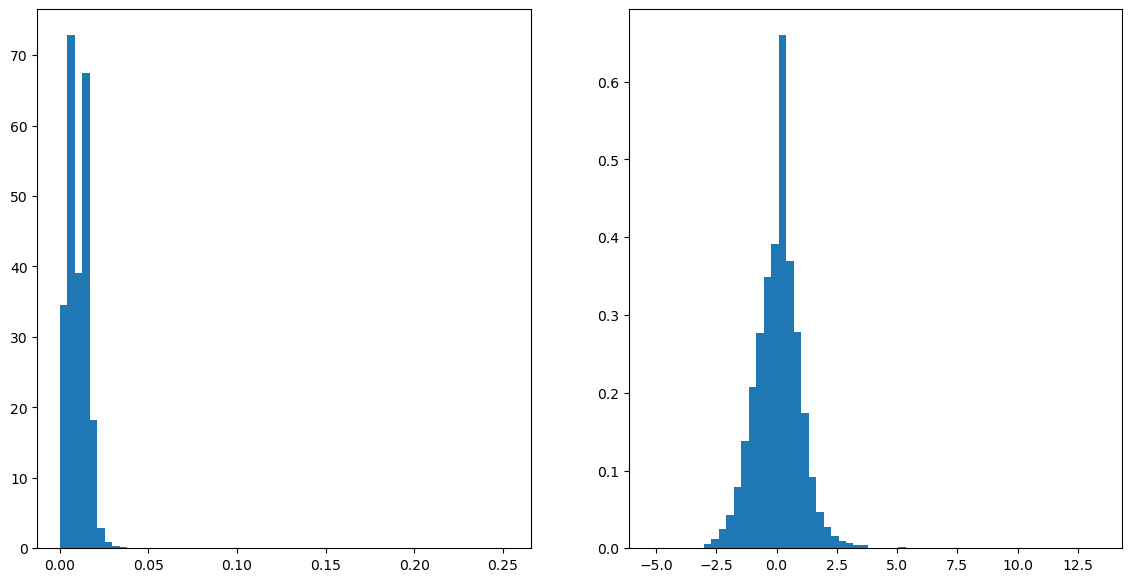

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:, 13], bins=60, density=True)
axs[1].hist(out[:, 13], bins=60, density=True)
plt.show()

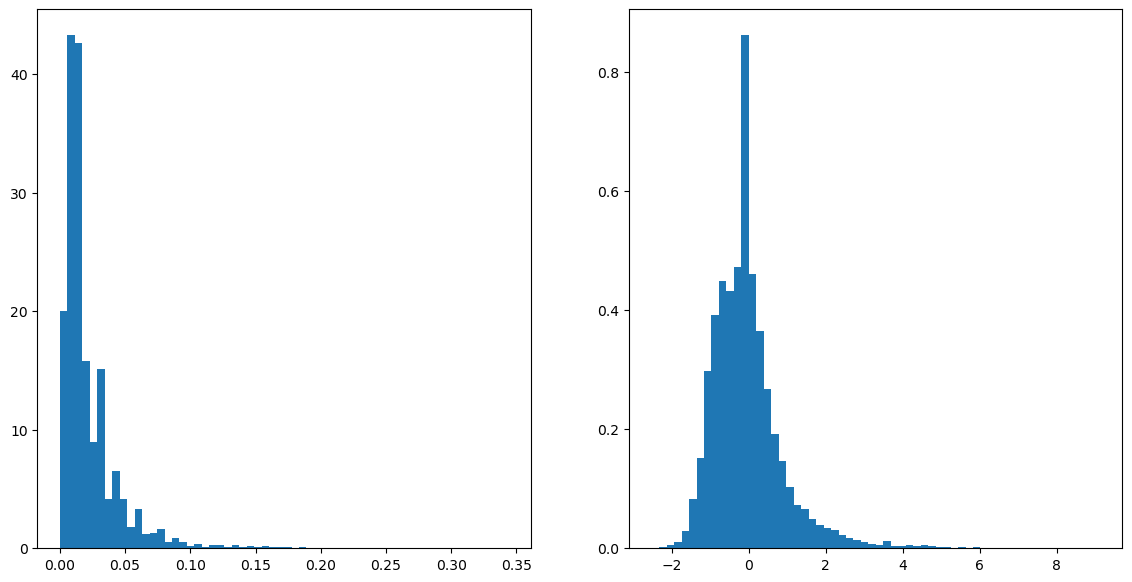

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   25], bins=60, density=True)
axs[1].hist(out[:, 25], bins=60, density=True)
plt.show()

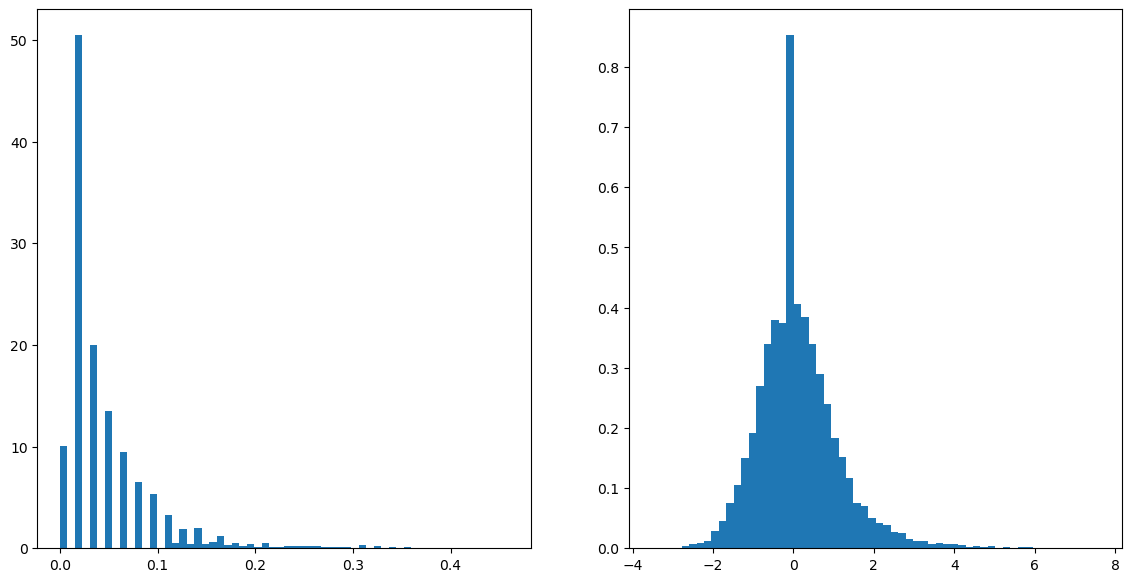

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   70], bins=60, density=True)
axs[1].hist(out[:, 70], bins=60, density=True)
plt.show()

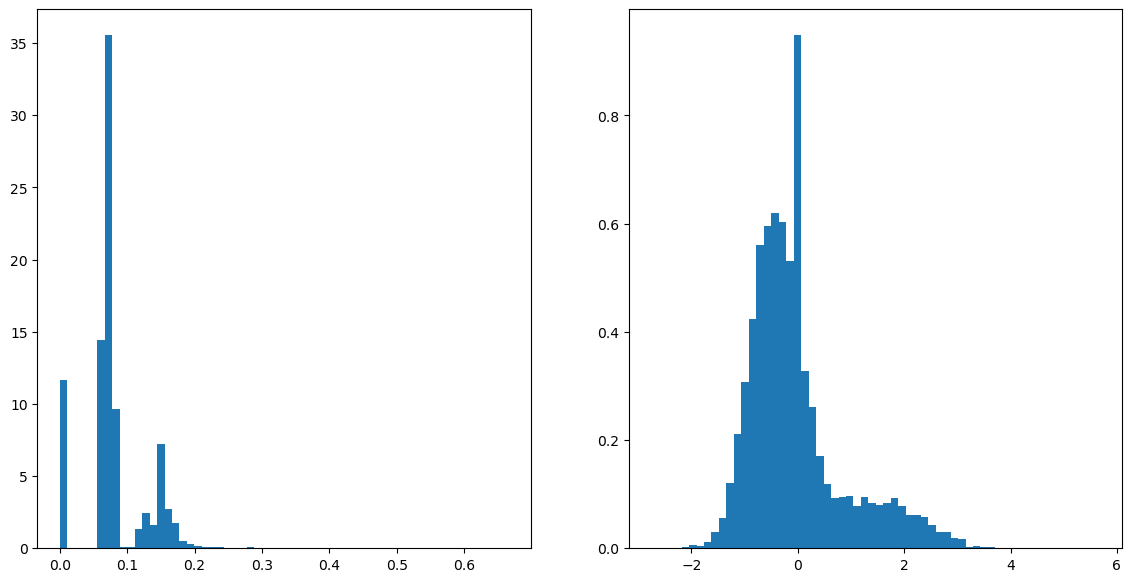

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   29], bins=60, density=True)
axs[1].hist(out[:, 29], bins=60, density=True)
plt.show()

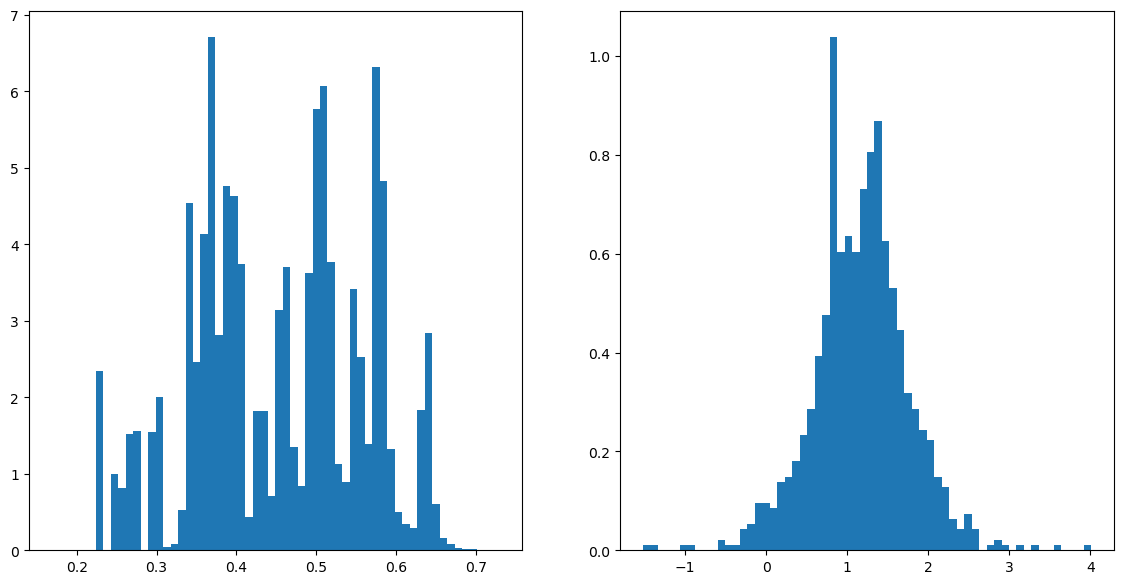

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[1].hist(torch.tensor(out).unflatten(0, (1024,  13)).numpy()[:, 7,  15], bins=60, density=True)
axs[0].hist(X[:, 15], bins=60, density=True)
plt.show()

In [5]:
f"{torch.cuda.mem_get_info(5)[0] / 1024 ** 2} MB"

'23174.0625 MB'

In [64]:
xin = X_in + 0.00 * torch.normal(torch.ones_like(X_in, device=DEV) * 0.5, torch.ones_like(X_in, device=DEV))
                   
torch.all(torch.isfinite(bijector.inv(xin).detach().cpu()))

tensor(True)

In [58]:
torch.all(torch.isfinite(bijector.inv(torch.tensor(X).flatten(0, 1).to(DEV)).detach().cpu()))

tensor(True)

In [13]:
X_processed = []
y_processed = []

for X, y in tqdm(val_loader):
    with torch.no_grad():
        X_in = X[:, :, half[0]:half[1]].flatten(0, 1).to(DEV)
        # X_out = bijector.inv(X_in).detach().cpu()
        X_out = X[:, :, :11].flatten(0, 1).detach().cpu()
        
        if not torch.all(torch.isfinite(X_out)):
            # find the culprits
            idx = torch.logical_not(torch.isfinite(X_out))
            idx = np.unique(np.where(idx)[0])
            print(f"Replacing {len(idx)} erroneous sample(s) with other data.")
            # then replace the erronous values and try again
            X_out[idx, :] = bijector.inv(prev_X_in[idx, :]).detach().cpu()
            
            # check if fixed after max number of iters or less
            if not torch.all(torch.isfinite(X_out)):
                raise ValueError("Failed to avoid non-finite values")
        # save working input to replace erroneous ones
        prev_X_in = X_in
                
    X = X_out.unflatten(0, (X.shape[0], X.shape[1])).numpy()
    #X = np.concatenate((X[:, :, :11], X_out.numpy()), 2)
    X_processed.append(X)
    y_processed.append(y)    

  0%|          | 0/90 [00:00<?, ?it/s]

In [7]:
X_train_first_half = np.concatenate(X_processed, axis=0)
y_train_first_half = np.concatenate(y_processed, axis=0)
X_train_first_half.shape, y_train_first_half.shape

((367131, 13, 11), (367131,))

In [14]:
X_val_first_half = np.concatenate(X_processed, axis=0)
y_val_first_half = np.concatenate(y_processed, axis=0)
X_val_first_half.shape, y_val_first_half.shape

((91782, 13, 11), (91782,))

In [41]:
X_train_second_half = np.concatenate(X_processed, axis=0)
y_train_second_half = np.concatenate(y_processed, axis=0)
X_train_second_half.shape, y_train_second_half.shape

((367131, 13, 97), (367131,))

In [43]:
X_val_second_half = np.concatenate(X_processed, axis=0)
y_val_second_half = np.concatenate(y_processed, axis=0)
X_val_second_half.shape, y_val_second_half.shape

((91782, 13, 97), (91782,))

In [9]:
np.mean(y_train_first_half == np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_train.npy")))

1.0

In [11]:
.shape

(367131, 13, 188)

In [12]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_train.npy"), np.concatenate((X_train_first_half, np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-X_train.npy"))), axis=2))

In [15]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_val.npy"), np.concatenate((X_val_first_half, np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-X_val.npy"))), axis=2))

In [55]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_val.npy"), y_val_first_half)

In [56]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_train.npy"), y_train_first_half)

In [62]:
temp = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-X_train.npy"))

In [25]:
temp = torch.randperm(20)
inv_temp = torch.empty_like(temp)
inv_temp[temp] = torch.arange(20)
torch.arange(0, 20)[temp][inv_temp]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [35]:
temp_out = bijector.inv(temp)
for i in range(80):
    if not torch.all(torch.isfinite(temp_out[:, i])):
        print(i)

0
3
5
10
12
14
15
17
20
22
24
25
28
32
35
36
37
38
39
47
48
50
51
53
55
56
60
64
66
67
68
70
75
77
78


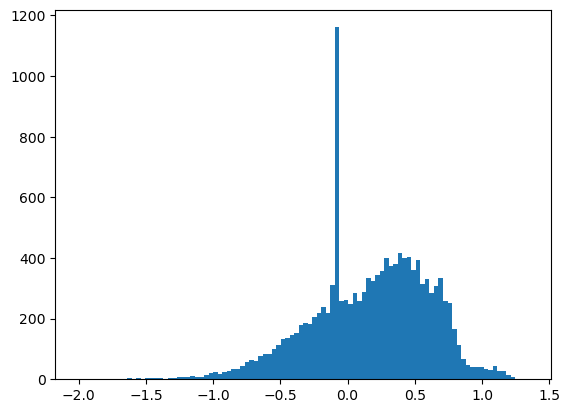

In [39]:
plt.hist(temp_out[:, 0].detach().cpu().numpy(), bins=100)
plt.show()

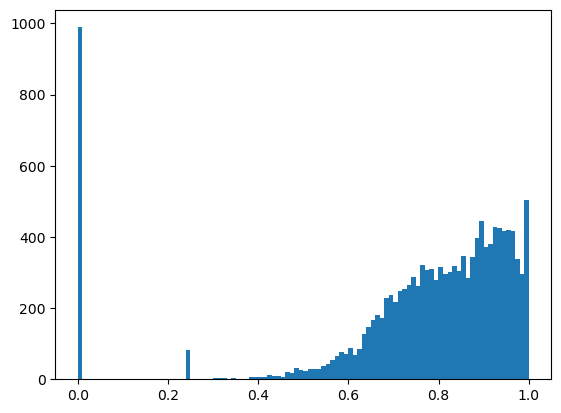

In [42]:
plt.hist(temp[:, 0].detach().cpu().numpy(), bins=100)
plt.show()

In [53]:
temp[np.where(~torch.isfinite(temp_out[:, 0]).cpu())[0], :]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [52]:
bijector.inv(temp[np.where(~torch.isfinite(temp_out[:, 0]).cpu())[0], 0])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Training model on RealNVP-transformed data

Step 1: Load the data

In [10]:
X_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_train.npy"))
y_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_train.npy"))
X_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-3-X_val.npy"))
y_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-2-y_val.npy"))

#preprocess = StandardScalerTimeSeries()
#X_train[:, :, 11:] = preprocess.fit_transform(X_train[:, :, 11:], y_train)
#X_val[:, :, 11:] = preprocess.transform(X_val[:, :, 11:])

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

train_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_train).type(torch.float32)
    ), **data_loader_kwargs)

val_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val).type(torch.float32),
        torch.from_numpy(y_val).type(torch.float32)
    ), **data_loader_kwargs)

In [11]:
from src.models.basic_grunet import GRUNetBasic

loss_fn = F.binary_cross_entropy
model = GRUNetBasic(188, 128, 2, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5], gamma=0.1)
early_stopper = experimentation.EarlyStopper(patience=10)

In [12]:
hist = experimentation.fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler, num_epochs=50, early_stopper=early_stopper, device_ids=[4], verbose=False)

Using device = cuda:4


  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
np.save(os.path.join(cfg['experiment_directory'], 'normalizing_flow_small_history.npy'), hist)

In [17]:
np.min(hist['val_loss'])

0.2249893479877048

In [18]:
np.min(hist['val_amex_metric'])

0.7698227349840046

In [8]:
standard_scaling = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
standard_scaling['val_loss'][0], standard_scaling['val_amex_metric'][0]

(array([0.22735007, 0.22445291, 0.2232345 , 0.22275956, 0.22212165,
        0.22215124, 0.22211825, 0.22168321, 0.22161712, 0.22160993,
        0.22161777, 0.22164823, 0.22166345, 0.22165659, 0.22168927]),
 array([0.77734793, 0.78128873, 0.78234227, 0.78462958, 0.78609896,
        0.78606435, 0.78632146, 0.78674466, 0.78688495, 0.78658075,
        0.78653513, 0.7865156 , 0.78651322, 0.78641881, 0.78657073]))

## Adaptive preprocessing layer as bijector

In [150]:
class AdaptiveScale(dist.torch_transform.TransformModule):
    """
    Todo
    """
    
    # setup params
    domain = dist.transforms.constraints.real_vector # or just real?
    codomain = dist.transforms.constraints.real_vector
    bijective = True
    
    def __init__(self, input_dim, init_sigma=0.1):
        super(AdaptiveScale, self).__init__(cache_size=1)
        
        self.input_dim = input_dim
        # learned standard deviation should be positive
        self.log_scale = nn.Parameter(
            torch.randn(self.input_dim) * init_sigma
        )
        self._cached_logDetJ = None
    
    def _params(self):
        # s = torch.exp(self.log_scale)
        return self.log_scale
    
    def _call(self, x):
        # apply scale
        return x * torch.exp(self.log_scale)
    
    def _inverse(self, y):
        x = y * torch.exp(-self.log_scale)
        return x
    
    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the elementwise determinant of the log Jacobian
        """
        return torch.sum(self.log_scale)
    
    def _inverse_log_abs_det_jacobian(self, x, y):
        return torch.sum(-self.log_scale)
    
class AdaptiveShift(dist.torch_transform.TransformModule):
    """
    Todo
    """
    
    # setup params
    domain = dist.transforms.constraints.real_vector # or just real?
    codomain = dist.transforms.constraints.real_vector
    bijective = True
    
    def __init__(self, input_dim, init_sigma=0.1):
        super(AdaptiveShift, self).__init__(cache_size=1)
        
        self.input_dim = input_dim
        # learned shift can be any real
        self.shift = nn.Parameter(
            torch.randn(self.input_dim) * init_sigma
        )
    
    def _params(self):
        # s = torch.exp(self.log_scale)
        return self.shift
    
    def _call(self, x):
        return x + self.shift
    
    def _inverse(self, y):
        return y - self.shift
    
    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the elementwise determinant of the log Jacobian
        """
        return torch.zeros(x.size(0), device=x.device, dtype=x.dtype)
    
    def _inverse_log_abs_det_jacobian(self, x, y):
        return torch.zeros(x.size(0), device=x.device, dtype=x.dtype)
        
class InvertBijector(dist.torch_transform.TransformModule):
    
     # setup params
    domain = dist.transforms.constraints.real_vector # or just real?
    codomain = dist.transforms.constraints.real_vector
    bijective = True
    
    def __init__(self, bijector):
        super(InvertBijector, self).__init__()
        
        self.bijector = bijector
        
    def _params(self):
        return self.bijector._params()
    
    def _call(self, x):
        return self.bijector.inv(x)
    
    def _inverse(self, y):
        return self.bijector(y)
    
    def log_abs_det_jacobian(self, x, y):
        return self.bijector._inverse_log_abs_det_jacobian(x, y)
    


In [217]:
input_dim = 177 * 13
DEV = torch.device('cuda', 5)

base_dist = dist.Normal(torch.zeros(input_dim, device=DEV), torch.ones(input_dim, device=DEV)).to_event(1)
bijector = dist.torch_transform.ComposeTransformModule([InvertBijector(AdaptiveScale(input_dim)), InvertBijector(AdaptiveShift(input_dim))]).to(DEV)
batch_preprocess_fn = lambda x : x[:, :, 11:].flatten(1, 2)
optimizer = torch.optim.Adam(bijector.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 8], gamma=0.1)

In [218]:
fit_bijector(bijector, base_dist, train_loader, optimizer=optimizer, scheduler=scheduler, batch_preprocess_fn=batch_preprocess_fn, num_epochs=20)

Fitting bijector:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

In [219]:
for X, _ in train_loader:
    break
x_in = X[:, :, 11:].flatten(1, 2)
out = bijector.inv(x_in.to(DEV)).detach().cpu().numpy()
x_in = x_in.numpy()
out.shape

(1024, 2301)

0.0056372983 0.9695771


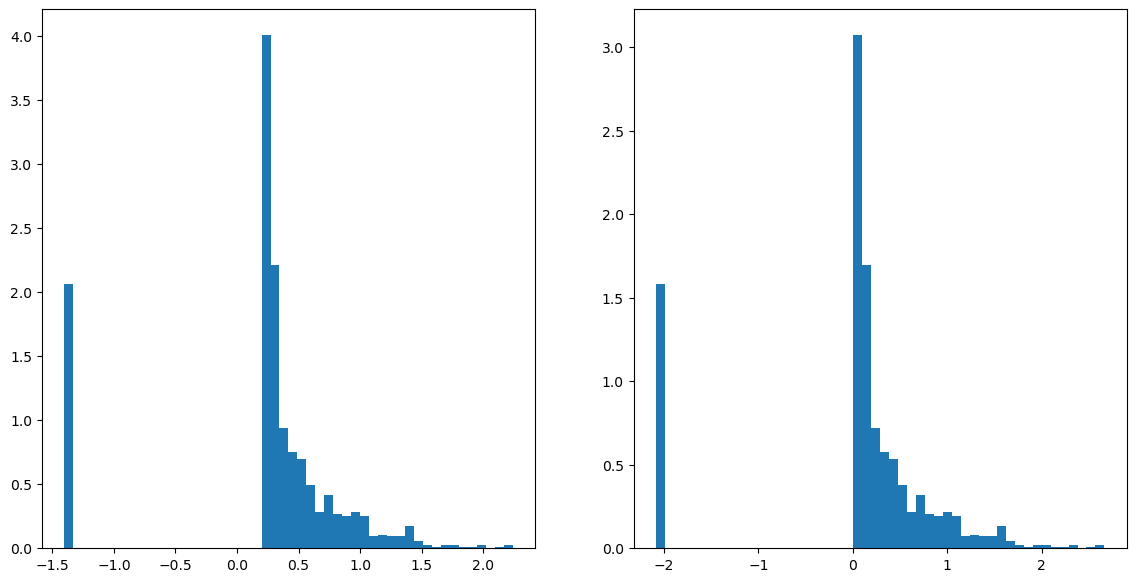

In [233]:
idx = 20
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(x_in[:, idx], density=True, bins=50)
axs[1].hist(out[:, idx], density=True, bins=50)
print(np.mean(out[:, idx]), np.std(out[:, idx]))
plt.show()

-0.021260072 0.9579581


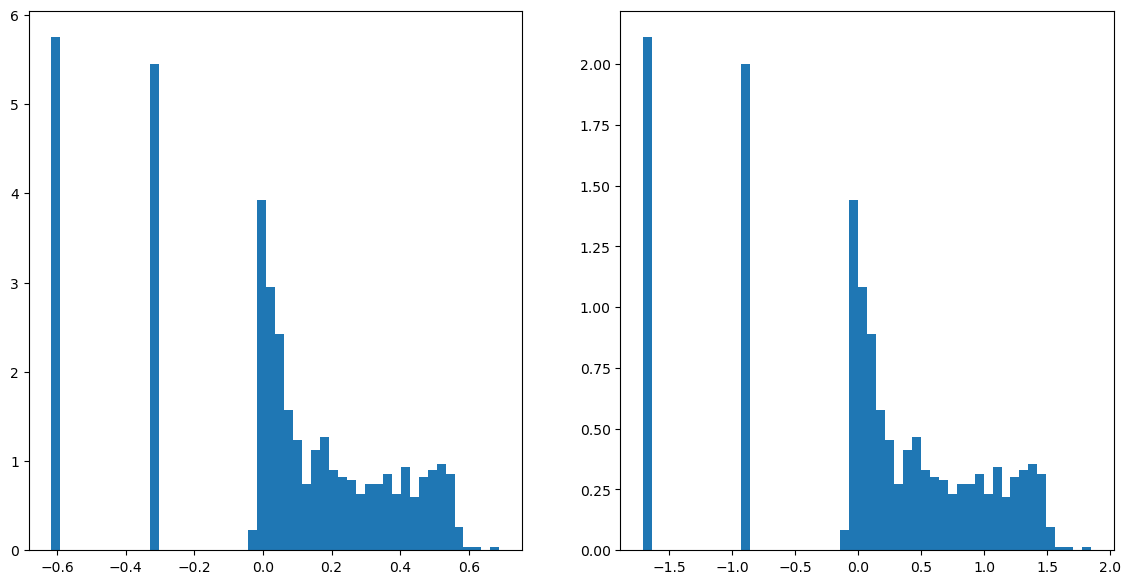

In [225]:
# this is with inverse scale first
idx = 17
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(x_in[:, idx], density=True, bins=50)
axs[1].hist(out[:, idx], density=True, bins=50)
print(np.mean(out[:, idx]), np.std(out[:, idx]))
plt.show()

In [226]:
post_fn = lambda x_in, x_out : np.concatenate((x_in[:, :, :11], x_out.unflatten(1, (13, 177))), axis=2) 
train_out = transform_data(bijector, train_loader, batch_preprocess_fn, post_fn)
val_out = transform_data(bijector, val_loader, batch_preprocess_fn, post_fn)

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [227]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-X_train.npy"), train_out[0])
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-y_train.npy"), train_out[1])

In [228]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-y_val.npy"), val_out[1])
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-X_val.npy"), val_out[0])

In [229]:
X_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-X_train.npy"))
y_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-y_train.npy"))
X_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-X_val.npy"))
y_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"Adaptive-flow-2-y_val.npy"))

#preprocess = StandardScalerTimeSeries()
#X_train[:, :, 11:] = preprocess.fit_transform(X_train[:, :, 11:], y_train)
#X_val[:, :, 11:] = preprocess.transform(X_val[:, :, 11:])

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

train_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_train).type(torch.float32)
    ), **data_loader_kwargs)

val_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val).type(torch.float32),
        torch.from_numpy(y_val).type(torch.float32)
    ), **data_loader_kwargs)

In [230]:
from src.models.basic_grunet import GRUNetBasic

loss_fn = F.binary_cross_entropy
model = GRUNetBasic(188, 128, 2, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stopper = experimentation.EarlyStopper(patience=5)
hist = experimentation.fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler, num_epochs=150, early_stopper=early_stopper, device_ids=[4], verbose=False)

Using device = cuda:4


  0%|          | 0/150 [00:00<?, ?it/s]

In [232]:
hist['val_amex_metric']

[0.7751133572510731,
 0.7792666108054113,
 0.7821375329941104,
 0.7828049453320886,
 0.7847454943359925,
 0.7852264198876152,
 0.7856403984224866,
 0.785814975297641,
 0.7857816247323063,
 0.7856861772035111,
 0.7858136607170364,
 0.7856695257403299,
 0.7854474108365223,
 0.7854811020432169,
 0.7853769618019574,
 0.7855221222044375]